In [1]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [2]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# Iniciar Data frame
df = append_dataframes()
df

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only
5,"Casa en Arriendo, TIBABUYES Bogotá D.C..",$1.100.000,3,2,69.0 m2,"Casa en conjunto cerrado, recién remodelada, c...",https://www.metrocuadrado.com/inmueble/arriend...,32.4,left_only
6,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,4,4,71.0 m2,casa ezquinera tres niveles excelente ubicacio...,https://www.metrocuadrado.com/inmueble/arriend...,60.9,left_only
7,"Casa en Arriendo, PORTALES DEL NORTE Bogotá D.C..",$1.400.000,4,2,82.0 m2,casa en conjunto cerrado consta de tres pisos ...,https://www.metrocuadrado.com/inmueble/arriend...,52.9,left_only
8,"Casa en Arriendo, URBANIZACION BOLIVIA ORIENTA...",$1.200.000,3,2,72.0 m2,Cómoda casa en sector residencial de Ciudadela...,https://www.metrocuadrado.com/inmueble/arriend...,40.9,left_only
9,"Casa en Arriendo, URBANIZACION AZAFRANES Bogot...",$1.400.000,4,2,100.0 m2,Casa en arriendo de 2 niveles en La Isabela 2 ...,https://www.metrocuadrado.com/inmueble/arriend...,33.3,left_only


Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [5]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [6]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

In [7]:
# Limpiamos n_rooms y n_baths, sujeto a cambios
df['n_rooms'] = df['n_rooms'].replace('5+', 6)
df['n_rooms'].fillna(3, inplace=True)
df['n_rooms'] = df['n_rooms'].apply(float)

df['n_bath'] = df['n_bath'].replace('5+', 6)
df['n_bath'].fillna(3, inplace=True)
df['n_bath'] = df['n_bath'].apply(float)

Vemos los Dtype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
property_type|rent_type|location    16379 non-null object
price                               16379 non-null float64
n_rooms                             16379 non-null float64
n_bath                              16379 non-null float64
surface                             16379 non-null float64
details                             16269 non-null object
url                                 16379 non-null object
metro_cuadrado                      16379 non-null float64
_merge                              16379 non-null category
dtypes: category(1), float64(5), object(3)
memory usage: 1.0+ MB


##### b)

In [9]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type','rent_type']] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location', 'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [10]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [11]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return 0
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return n


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [12]:
# Limpiamos n_garajes, sujeto a cambios
df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(float)

### 4- . Clasificación por tipo de producto

In [13]:
# Inicializamos la columna tipo
df['tipo'] = -1


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [14]:
df

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,1.666667e+04,1.0,-1
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,3.930000e+04,1.0,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8.333333e+03,0.0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,4.788732e+04,0.0,-1
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only,BALCONES DE ORIENTE Bogotá D.C..,Casa,Arriendo,1.625000e+04,1.0,1
5,1100000.0,3.0,2.0,69.0,"Casa en conjunto cerrado, recién remodelada, c...",https://www.metrocuadrado.com/inmueble/arriend...,32.4,left_only,TIBABUYES Bogotá D.C..,Casa,Arriendo,1.594203e+04,0.0,-1
6,3400000.0,4.0,4.0,71.0,casa ezquinera tres niveles excelente ubicacio...,https://www.metrocuadrado.com/inmueble/arriend...,60.9,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,4.788732e+04,1.0,-1
7,1400000.0,4.0,2.0,82.0,casa en conjunto cerrado consta de tres pisos ...,https://www.metrocuadrado.com/inmueble/arriend...,52.9,left_only,PORTALES DEL NORTE Bogotá D.C..,Casa,Arriendo,1.707317e+04,1.0,1
8,1200000.0,3.0,2.0,72.0,Cómoda casa en sector residencial de Ciudadela...,https://www.metrocuadrado.com/inmueble/arriend...,40.9,left_only,URBANIZACION BOLIVIA ORIENTAL Bogotá D.C..,Casa,Arriendo,1.666667e+04,1.0,-1
9,1400000.0,4.0,2.0,100.0,Casa en arriendo de 2 niveles en La Isabela 2 ...,https://www.metrocuadrado.com/inmueble/arriend...,33.3,left_only,URBANIZACION AZAFRANES Bogotá D.C..,Casa,Arriendo,1.400000e+04,1.0,1


Hay que arreglar, hay casas con menos de 80 de surface

### 5- .

In [15]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [16]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)
upz

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,PALERMO
1,UPZ100,1,GALERIAS,2.375681e+06,BELALCAZAR
2,UPZ100,1,GALERIAS,2.375681e+06,SEARS
3,UPZ100,1,GALERIAS,2.375681e+06,GALERIAS
4,UPZ100,1,GALERIAS,2.375681e+06,BANCO CENTRAL
5,UPZ100,1,GALERIAS,2.375681e+06,EL CAMPIN
6,UPZ83,1,LAS MARGARITAS,1.472415e+06,SAN JOSE
7,UPZ83,1,LAS MARGARITAS,1.472415e+06,LAS MARGARITAS
8,UPZ107,1,QUINTA PAREDES,1.739560e+06,CENTRO NARIÑO
9,UPZ107,1,QUINTA PAREDES,1.739560e+06,GRAN AMERICA


In [17]:
# Inicializamos la columna
df['upz'] = -1

def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    codigos_upl = list(upz['UPlCodigo'])
    
    for codigo, locacion in zip(codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index
        
        for i in indice:
            df.loc[i,'upz'] = codigo
    
    return df


df = clasifica_upz(df)

In [18]:
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo,upz
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1.0,-1,UPZ101
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1.0,1,-1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0.0,1,UPZ75


In [19]:
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'] != -1])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [20]:
est_poblacion = pd.read_csv('./data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns = ['Unnamed: 0', 'nomupz'], inplace = True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [21]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on = 'upz',how = 'left')

In [22]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns = {'UPlCodigo' : 'upz'})
ind_inseg.drop(columns=['UPlNombre2','Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [23]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on = 'upz',how = 'left')

In [24]:
per_areas_verdes = pd.read_csv('./data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [25]:
per_areas_verdes.rename(columns={'upz': 'zona','cod_upz': 'upz'},inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'],inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [26]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on = 'upz',how = 'left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [27]:
df.replace(np.inf, np.nan,inplace=True)
df.replace(-np.inf, np.nan,inplace=True)
#df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 25 columns):
price                                      16381 non-null float64
n_rooms                                    16381 non-null float64
n_bath                                     16381 non-null float64
surface                                    16381 non-null float64
details                                    16271 non-null object
url                                        16381 non-null object
metro_cuadrado                             16381 non-null float64
_merge                                     16381 non-null category
location                                   16381 non-null object
property_type                              16381 non-null object
rent_type                                  16381 non-null object
precio_m2                                  16365 non-null float64
n_garajes                                  16381 non-null float64
tipo                                 

# P2

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

def estilo():
    sns.set_style('dark')
    sns.despine()

In [29]:
names = ['numeric', 'categorical']
# Se crea una lista con las columnas numericas
numeric = ['price', 'n_rooms', 'n_bath', 'surface', 'metro_cuadrado', 'precio_m2',
       'n_garajes', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc',
       'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
       'areas_verdes_perc'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

In [30]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

price
n_rooms
n_bath
surface
metro_cuadrado
precio_m2
n_garajes
personas
trabajoinf_ninos_5_17_anos_perc
trabajoinfampliado_ninos_5_17_anos_perc
jovenes_14_24_anos_nini_perc
indice_envegecimiento
jefe_mujer_perc
adultos_mayores_pobres_perc
indice_inseguridad
areas_verdes_perc


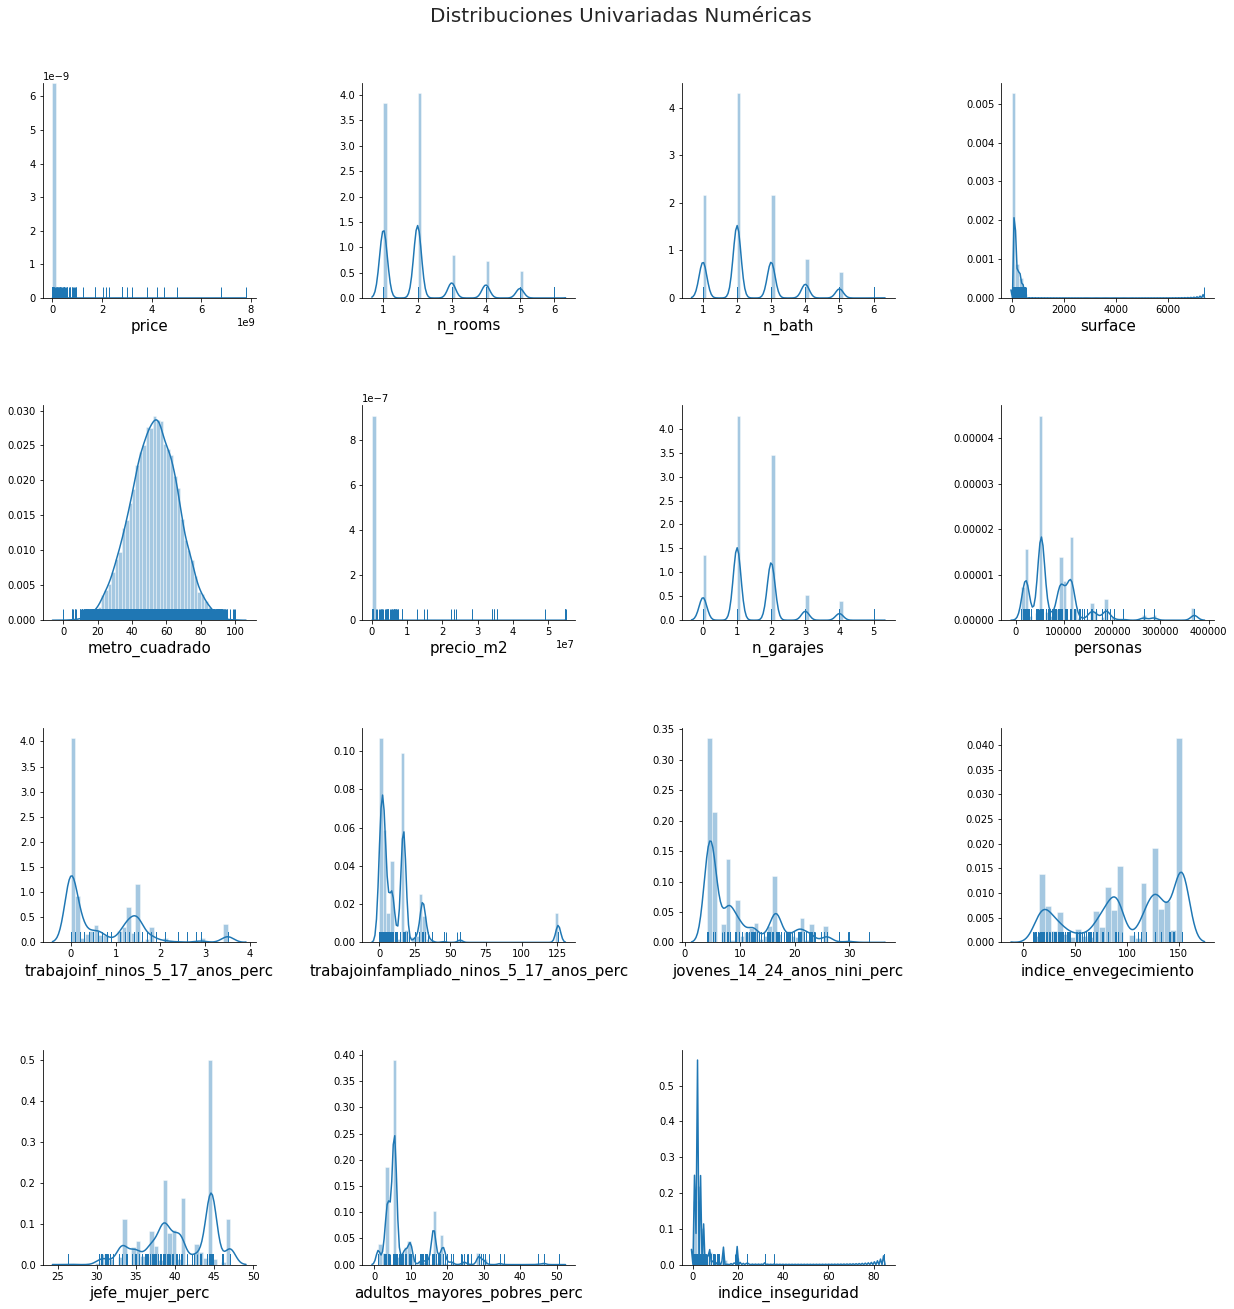

In [31]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    print(col)
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

In [32]:
# Datos faltantes
import missingno as msno
df.replace('nan',np.nan,inplace=True)
print('Valores nan')
print(df.isnull().sum())
print('Mayor info perdida')
print(df.isnull().sum().nlargest(10))

Valores nan
numeric      price                                         0
             n_rooms                                       0
             n_bath                                        0
             surface                                       0
             metro_cuadrado                                0
             precio_m2                                    16
             n_garajes                                     0
             personas                                   1329
             trabajoinf_ninos_5_17_anos_perc            1329
             trabajoinfampliado_ninos_5_17_anos_perc    1329
             jovenes_14_24_anos_nini_perc               1329
             indice_envegecimiento                      1329
             jefe_mujer_perc                            1329
             adultos_mayores_pobres_perc                1329
             indice_inseguridad                         1329
             areas_verdes_perc                          1329
categorical 

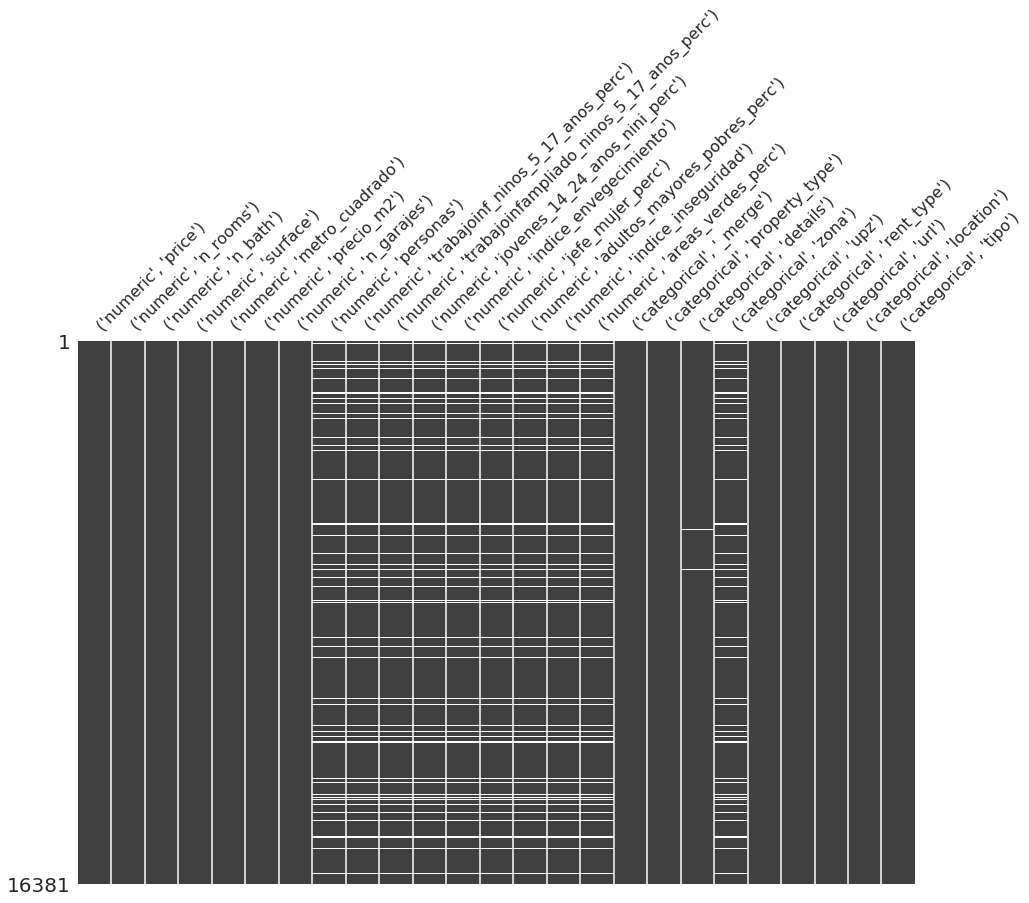

In [33]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=False)

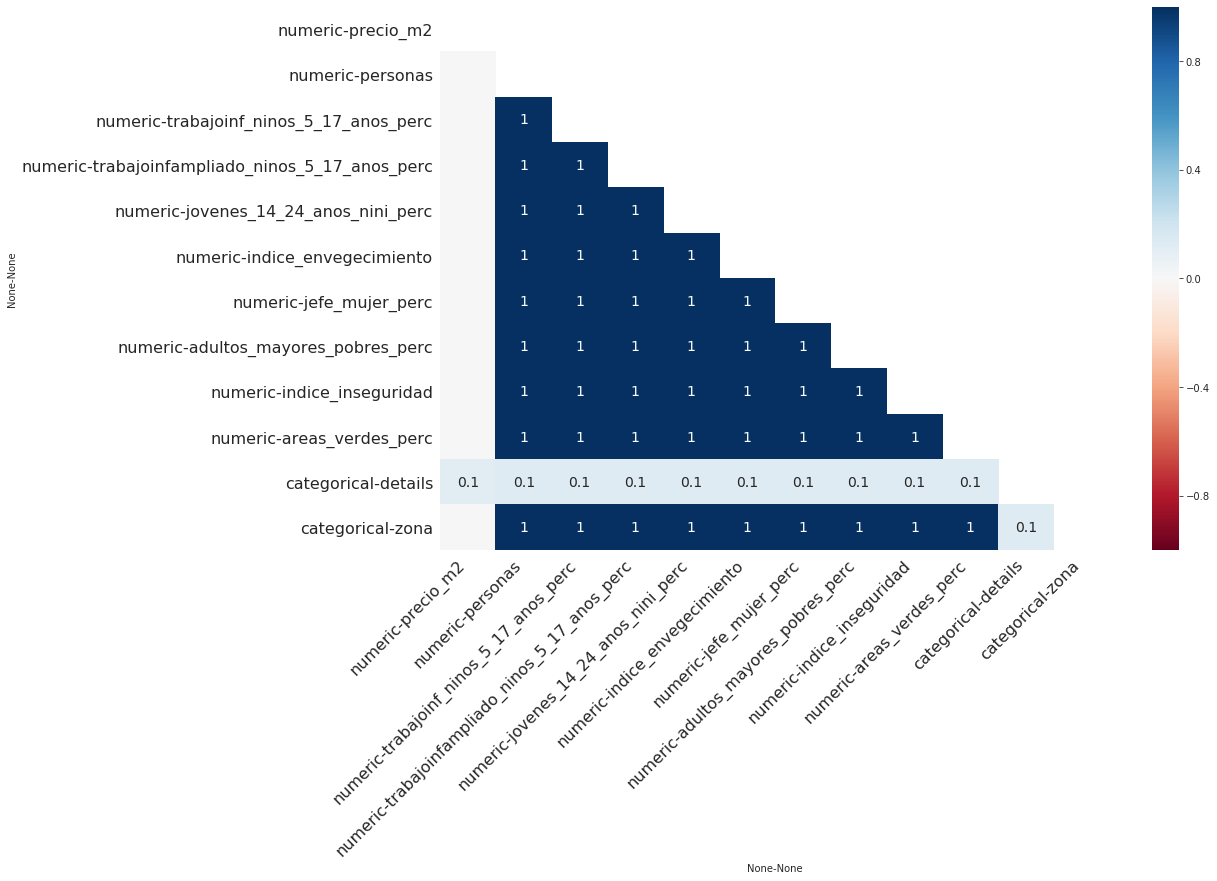

In [34]:
# Correlaciones de nulidad entre pares de variables
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)

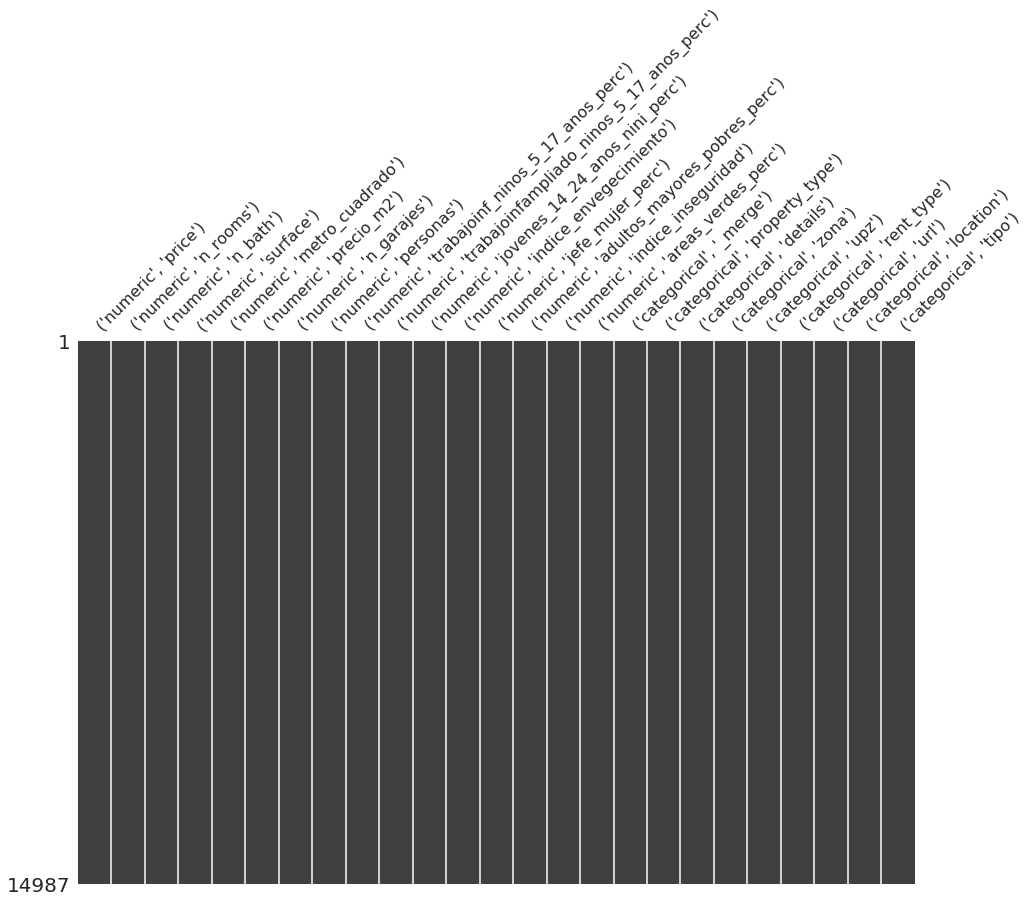

In [35]:
# dropear no mas
df1=df.copy()
df1.dropna(inplace=True)
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df1,ax = ax, sparkline=False)

In [36]:
# Eliminar filas con datos faltantes
df1=df.copy()
df1.dropna(inplace=True)


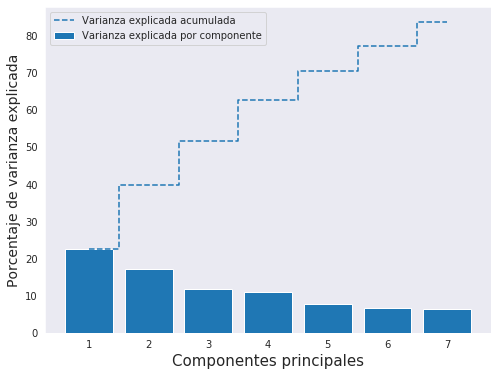

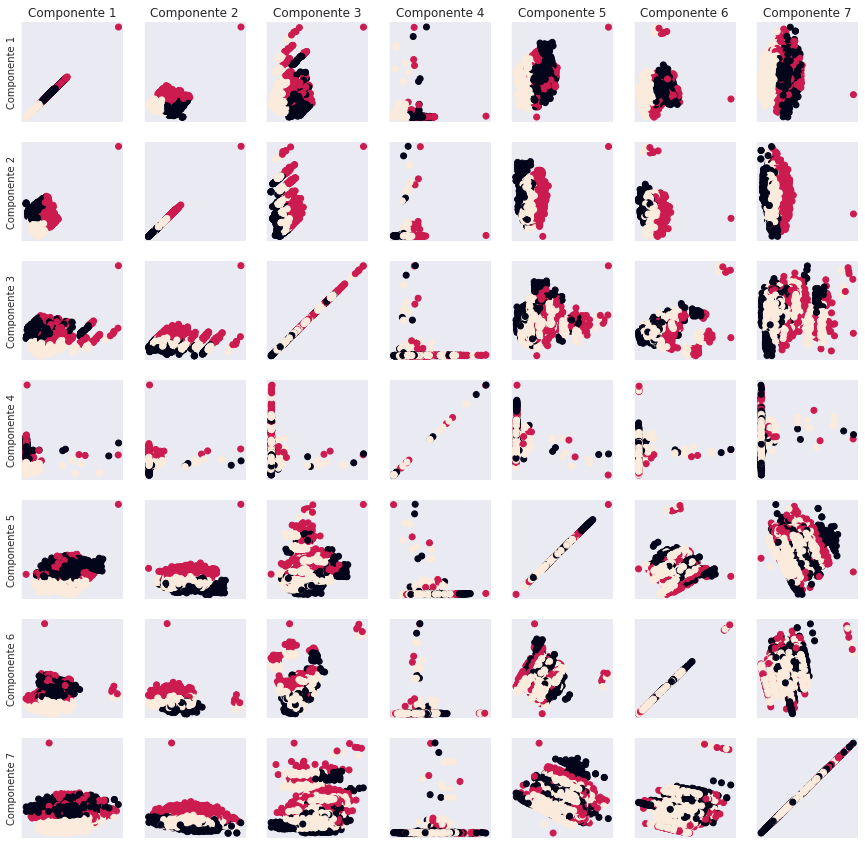

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
df_1=scaler.fit_transform(df1['numeric'])


n_com=7
pca=PCA(n_components=n_com)
pecea=pca.fit_transform(df_1)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
cum_var_exp = np.cumsum(per_var)
plt.rcParams["figure.figsize"] = [8.0, 6.0]
#the following code makes a fancy looking plot using PC1 and PC2
plt.bar(x=range(1,len(per_var)+1), height=per_var,label='Varianza explicada por componente')
plt.step(np.arange(n_com)+1, cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada',fontsize=14)
plt.xlabel('Componentes principales',fontsize=15)
plt.legend(loc='best')
plt.show()


n_clu=3
kmeans=KMeans(n_clusters=n_clu).fit_predict(pecea)


fig, axes =plt.subplots(n_com,n_com,figsize=(15,15))
fig.suptitle('')

for i in range(n_com):
    for j in range(n_com):
        axes[i,j].scatter(pecea[:,i],pecea[:,j],c=kmeans)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        estilo()
        if i==0:
            axes[i,j].set_title('Componente '+str(j+1))
        if j==0:
            axes[i,j].set(ylabel='Componente '+str(i+1))

plt.show()





In [38]:
# Evaluar como se distribuyen los upz's en esos clusters
# cuantos hay
print('hay ',len(df1.categorical.upz.unique()),' diferentes upz')
#agregar cluster
#df1.loc['categorical','upz_cluster']=kmeans
print(df1.shape)
print(kmeans.shape)

df1[('categorical','upz_cluster')]=kmeans

hay  100  diferentes upz
(14987, 25)
(14987,)


In [39]:
upz_assignment={upz : 0 for upz in df1.categorical.upz.unique()}
for upz in df1.categorical.upz.unique():
    cluster_aparition=[]
    for k in np.arange(n_clu):
        s=sum((df1.categorical.upz==upz) & (df1.categorical.upz_cluster==k))
        cluster_aparition.append(s)
    upz_assignment[upz]=cluster_aparition.index(max(cluster_aparition))
    
column=[]
for upz in df1.categorical.upz:
    column.append(upz_assignment[upz])
df1[('categorical','upz_group')]=column

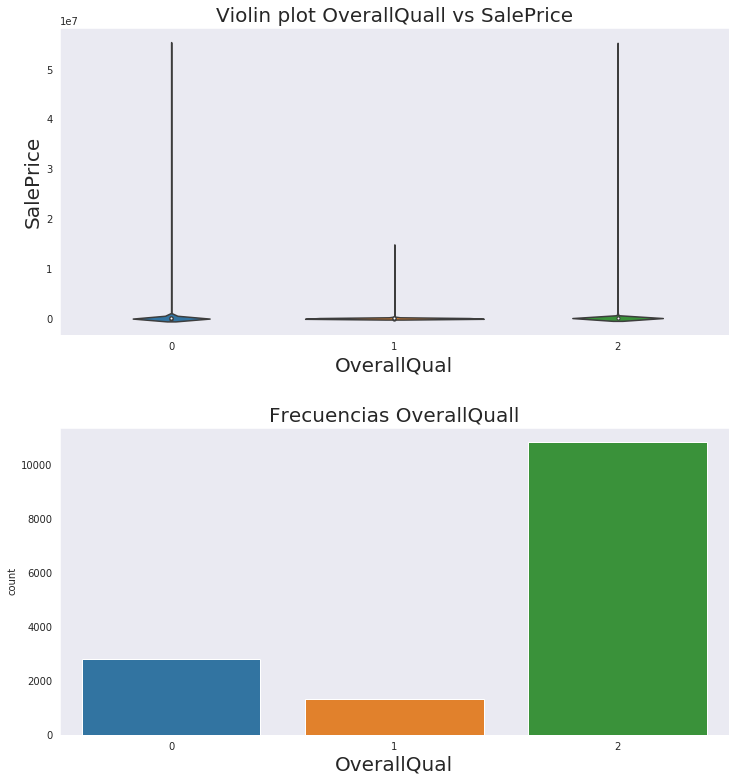

In [40]:
# Sirve para fija el tamaño de lasetiquetas del plot
fontdict = {'fontsize':20}

# Estrucutra de figura y axes
fig, ax = plt.subplots(2,1,figsize=[12,13])

# violin plot --> equivalente a catplot(kind = 'violin')

sns.violinplot(('categorical', 'upz_group'),
            y=('numeric', 'precio_m2'),
            data=df1,
            kind='violin',
            ax=ax[0])

sns.countplot(df1[('categorical','upz_group')], ax=ax[1])

ax[0].set_xlabel('OverallQual', fontdict)
ax[1].set_xlabel('OverallQual', fontdict)

ax[0].set_ylabel('SalePrice', fontdict)
ax[0].set_title('Violin plot OverallQuall vs SalePrice', fontdict)
ax[1].set_title('Frecuencias OverallQuall', fontdict)

h, w = (.3, .1)
plt.subplots_adjust(wspace=w, hspace=h)